In [1]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import shutil
import time
from collections import OrderedDict

import numpy as np
import pandas as pd
import wandb  # Import Wandb
import yaml
from scipy import integrate

# --- Competition Metric Functions (Copied from evaluation script) ---
from scipy.ndimage import distance_transform_edt
"""

"""
from surface_distance import (
    compute_dice_coefficient,
    compute_surface_dice_at_tolerance,
    compute_surface_distances,
)
from tqdm import tqdm


In [2]:
# local imports
from src.eval_tools import (
    compute_multi_class_dsc,
    compute_multi_class_nsd,
    generate_clicks,
)
from src.viz_tools import center_of_mass, save_volume_viz

from segfm3d_nora_team.src.sammed3d import SAMMed3DPredictor



GPU not available or CuPy/cuCIM error (No module named 'cupy'). Using SciPy for EDT.


ModuleNotFoundError: No module named 'segfm3d_nora_team'

In [10]:
import yaml

config = yaml.safe_load(open("/nfs/norasys/notebooks/camaret/segfm3d_nora_team/config.yaml"))

In [11]:
img_dir = os.path.join(config["VAL_DIR"], "3D_val_npz")
gt_dir = os.path.join(config["VAL_DIR"], "3D_val_gt_interactive_seg")
cases = sorted([f for f in os.listdir(img_dir) if f.endswith(".npz")])

In [12]:
cases.index("CT_AbdTumor_PETCT_27d69a8466.npz")
len(os.listdir(os.path.join(config["RESULTS_DIR"], "sammed3d")))

40

In [13]:
case_filename = cases[0]
case_name = os.path.splitext(case_filename)[0]
input_filepath = os.path.join(img_dir, case_filename)
gt_filepath = os.path.join(gt_dir, case_filename)

In [14]:
data = np.load(input_filepath, allow_pickle=True)
gt_data = np.load(gt_filepath)
image = data["imgs"]
spacing = data["spacing"]
spacing = [spacing[2], spacing[0], spacing[1]] # z, x, y
gts = gt_data["gts"]
print(image.shape)
initial_bbox = data.get("boxes", None)  # Use .get for optional keys

final_pred = np.zeros_like(image, dtype=np.uint8)



(63, 512, 512)


In [19]:
gt_text = np.load("/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/data/CT_AMOS_amos_0230(1).npz", allow_pickle=True)
print(list(gt_text.keys()))
gt_text["gts"].shape

['gts', 'spacing']


(162, 512, 512)

In [ ]:
# occurences of each class in the gt
unique, counts = np.unique(gts, return_counts=True)
print("Unique classes and their counts in the GT:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} pixels")

np.argsort(counts)


Unique classes and their counts in the GT:
Class 0: 15737952 pixels
Class 1: 68435 pixels
Class 2: 41774 pixels
Class 3: 40906 pixels
Class 4: 5216 pixels
Class 5: 4438 pixels
Class 6: 413327 pixels
Class 7: 59994 pixels
Class 8: 25564 pixels
Class 9: 33707 pixels
Class 10: 20782 pixels
Class 11: 1212 pixels
Class 12: 1584 pixels
Class 13: 17292 pixels
Class 14: 34245 pixels
Class 15: 8644 pixels


array([11, 12,  5,  4, 15, 13, 10,  8,  9, 14,  3,  2,  7,  1,  6,  0])

In [ ]:
# pick the largest class : 6
class_id = 1
print(f"GT center of mass for {case_name}:")
print(f"Center of mass coordinates (z, y, x): {center_of_mass(gts==class_id)}")
if initial_bbox is not None:
    bbox = initial_bbox[class_id-1] # class 0 is not in the bbox list
    print(f"Initial bounding box for {case_name}: {bbox}")
    img_bbox = np.zeros_like(image)
    img_bbox[
        bbox['z_min'] : bbox['z_max'],
        bbox['z_mid_y_min'] : bbox['z_mid_y_max'],
        bbox['z_mid_x_min'] : bbox['z_mid_x_max'],
        
        
        
    ] = class_id

GT center of mass for CT_AMOS_amos_0018:
Center of mass coordinates (z, y, x): (41.16563162124644, 243.3364214217871, 374.5257251406444)
Initial bounding box for CT_AMOS_amos_0018: {'z_min': 32, 'z_max': 50, 'z_mid': 41, 'z_mid_x_min': 329, 'z_mid_y_min': 189, 'z_mid_x_max': 416, 'z_mid_y_max': 313}


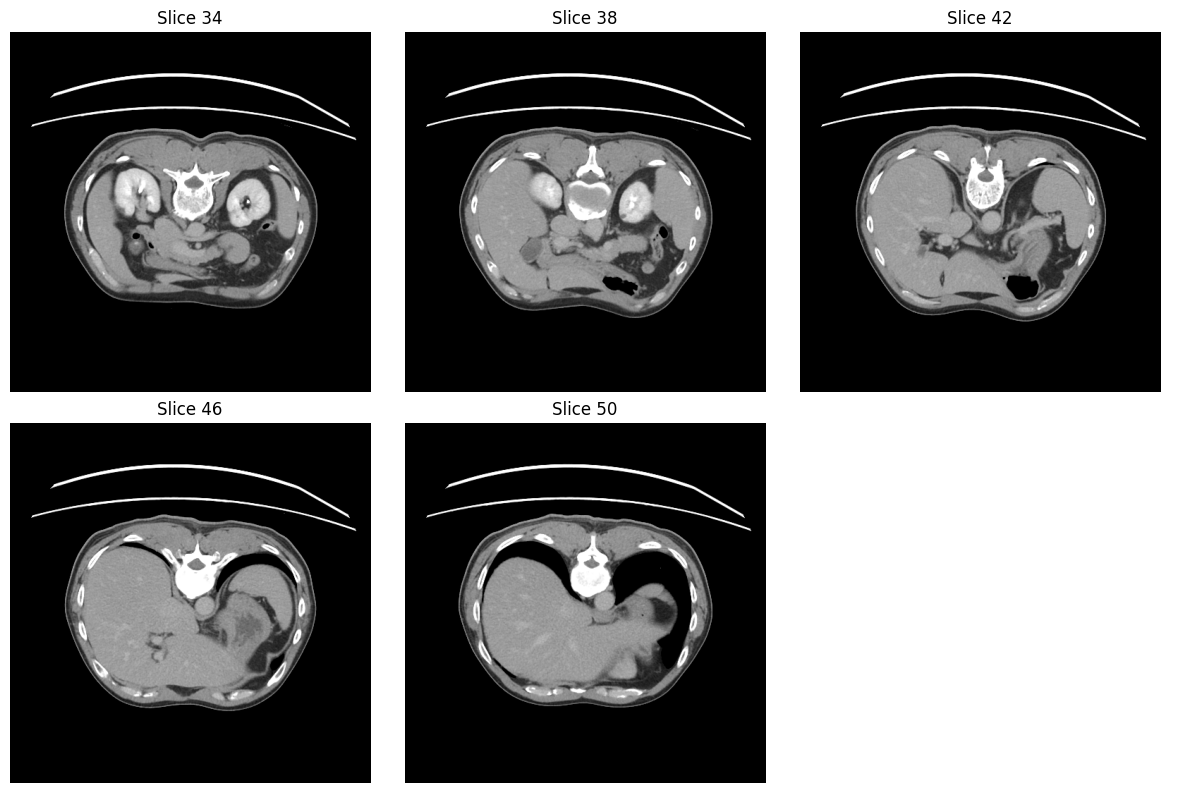

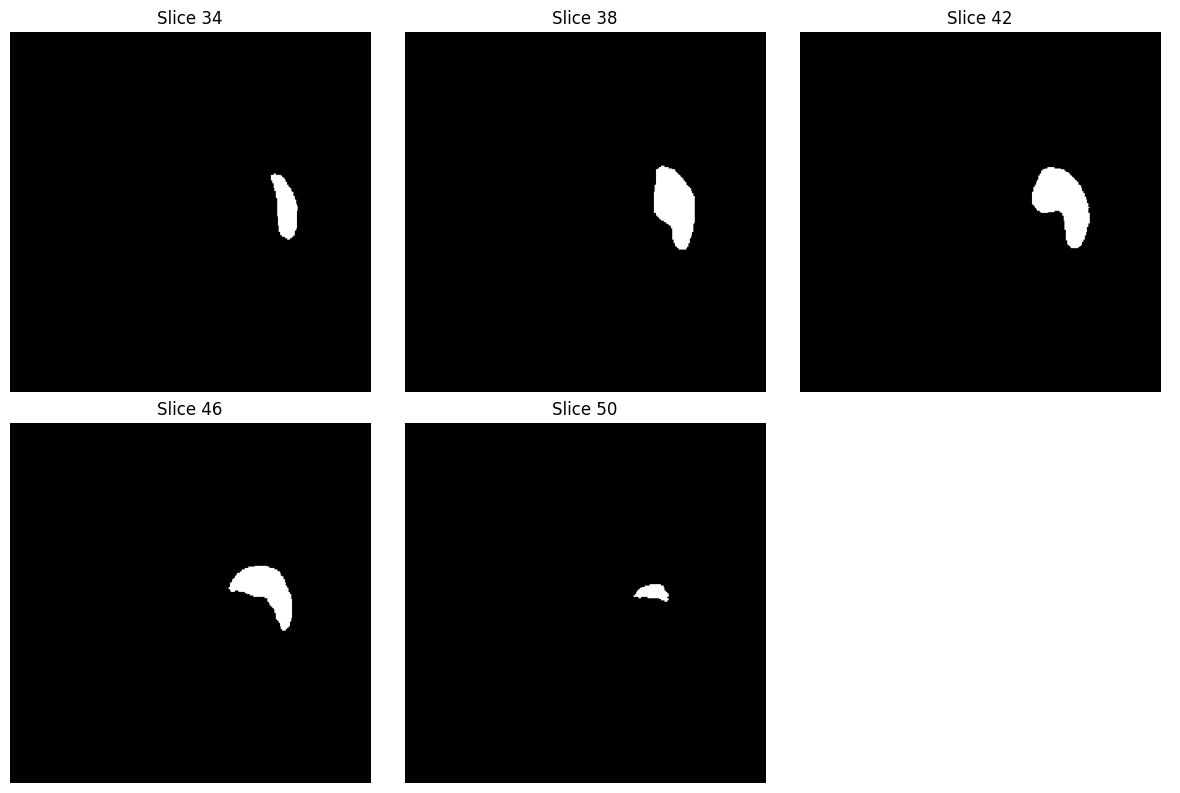

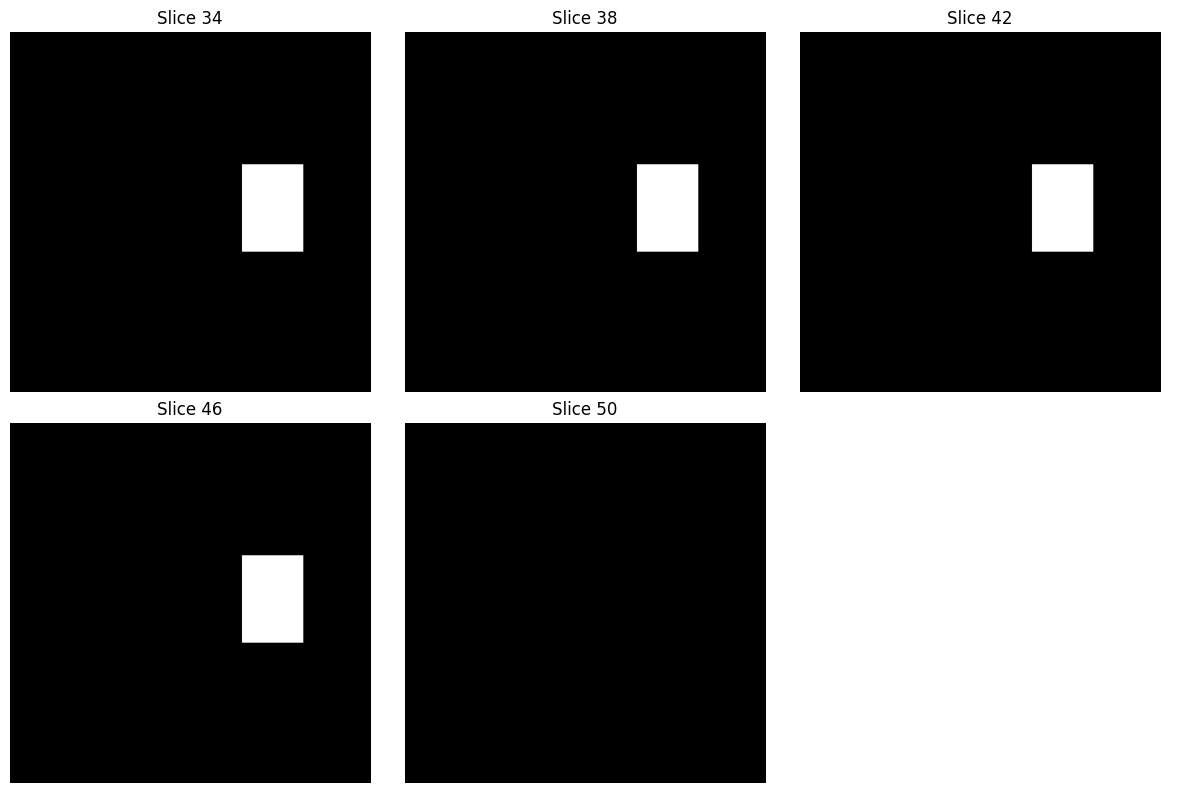

In [ ]:
save_volume_viz(image, slice_indices = list(range(34,51,4)), show=True)
save_volume_viz(gts==class_id, slice_indices = list(range(34,51,4)), show=True,) 
save_volume_viz(img_bbox, slice_indices = list(range(34,51,4)), show=True,) 


In [ ]:
import medim
model = medim.create_model("SAM-Med3D",
                            pretrained=True,
                            checkpoint_path=config["SAM_CKPT_PATH"],)

creating model SAM-Med3D
try to load pretrained weights from /nfs/norasys/notebooks/camaret/SAM-Med3D/ckpt/sam_med3d_turbo_bbox_cvpr.pth


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [ ]:
import sys
sys.path.append(config["SAM_REPO_DIR"])
from medim_infer import (
    random_sample_next_click,
    data_postprocess,
    data_preprocess,
)

In [ ]:
center_point = (image.shape[0]//2, image.shape[1]//2, image.shape[2]//2)
# cls_gt = create_gt_arr(image.shape, center_point, category_index=class_id)
# just a bbox around the center point (size 5)
# we modify this to use our bbox
cls_gt = img_bbox

In [ ]:
np.unique(cls_gt, return_counts=True)

(array([0, 1], dtype=uint8), array([16320888,   194184]))

In [ ]:
# previous prediction
prev_pred = np.zeros_like(image, dtype=np.uint8)
# TODO : include this for real 
cls_prev_seg = prev_pred==class_id

In [ ]:

start_time = time.time()
roi_image, roi_label, roi_prev_seg, meta_info = data_preprocess(image, cls_gt, cls_prev_seg,
                                                orig_spacing=spacing, 
                                                category_index=class_id)
print(f"Preprocessing time: {time.time() - start_time:.2f} seconds")

roi_image shape: torch.Size([1, 1, 128, 128, 128])


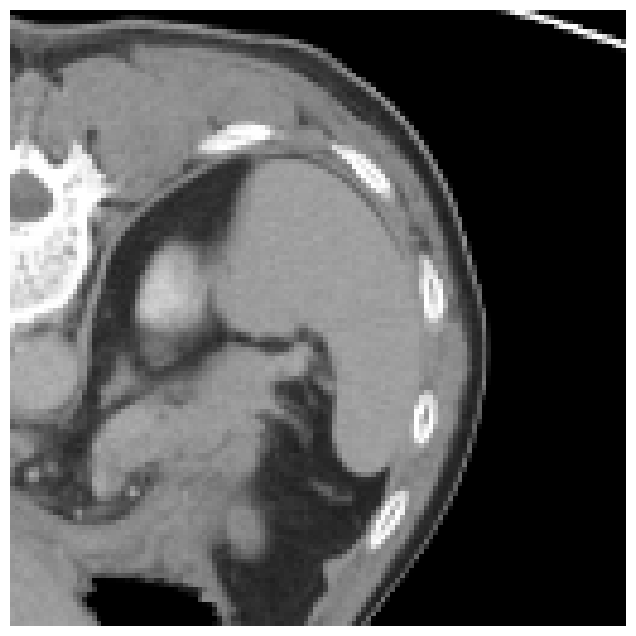

roi_label shape: torch.Size([1, 1, 128, 128, 128])


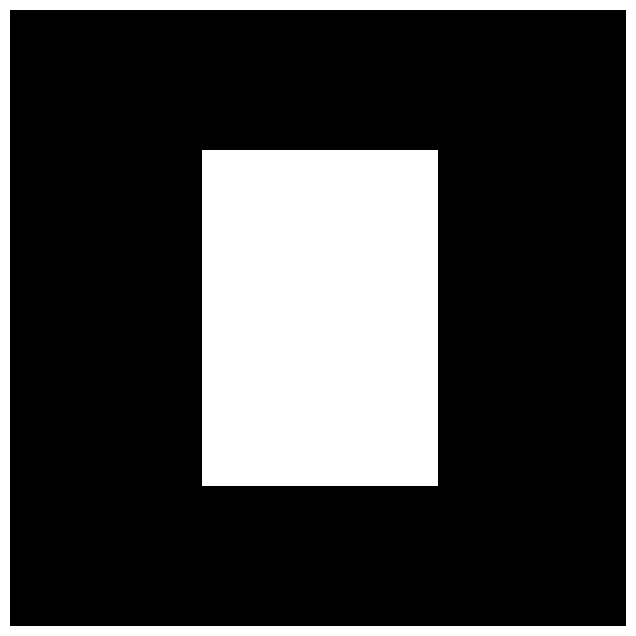

roi_prev_seg shape: torch.Size([1, 1, 128, 128, 128])


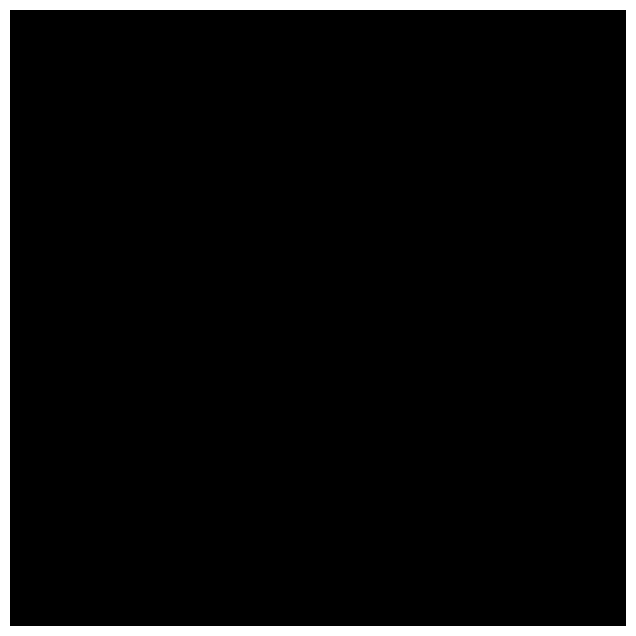

meta_info: {'padding_params': (0, 0, 0, 0, 0, 0), 'cropping_params': (73, 9, 78, 83, 146, 15), 'ori_roi': (73, 201, 78, 206, 146, 274), 'orig_shape': (63, 512, 512), 'resampled_shape': ((210, 289, 289),)}


In [ ]:
import torch


print(f"roi_image shape: {roi_image.shape}")#
save_volume_viz(roi_image[0][0], slice_indices = None, show=True)
print(f"roi_label shape: {roi_label.shape}")
save_volume_viz(roi_label[0][0], slice_indices = None, show=True)
print(f"roi_prev_seg shape: {roi_prev_seg.shape}")
save_volume_viz(roi_prev_seg[0][0], slice_indices = None, show=True)
print(f"meta_info: {meta_info}")


In [ ]:
# model prediction

start_time = time.time()
image_embeddings = model.image_encoder(roi_image.to(device))
print(f"image_embeddings shape: {image_embeddings.shape}")
print(f"image_embeddings : {image_embeddings}")

print(f"image embedding time: {time.time() - start_time:.2f} seconds")

image_embeddings shape: torch.Size([1, 384, 8, 8, 8])
image_embeddings : tensor([[[[[-2.4206e-01, -2.3378e-01, -2.3745e-01,  ..., -4.2792e-01,
            -3.7864e-01, -3.3473e-01],
           [-2.1735e-01, -2.1551e-01, -2.1862e-01,  ..., -1.5432e-01,
            -2.1212e-01, -1.9543e-01],
           [ 1.4609e-01,  1.1499e-01, -1.1798e-02,  ..., -7.7610e-02,
            -8.3710e-02, -2.1282e-01],
           ...,
           [-1.9413e-01, -1.1957e-01, -1.0102e-01,  ..., -1.3686e-01,
            -1.5911e-01, -1.9013e-01],
           [-8.3994e-02, -1.4807e-01, -1.8832e-01,  ..., -3.0578e-01,
            -3.1138e-01, -2.8861e-01],
           [-2.8463e-01, -2.8269e-01, -1.7472e-01,  ..., -3.7368e-01,
            -3.6476e-01, -3.0842e-01]],

          [[-2.1182e-01, -2.3625e-01, -2.4139e-01,  ..., -3.1629e-01,
            -2.8036e-01, -2.5567e-01],
           [-2.0820e-01, -1.1899e-01, -1.4282e-01,  ..., -1.1505e-01,
            -1.6014e-01, -1.6479e-01],
           [ 5.8055e-02,  3.3941e-01,

In [ ]:
import torch.nn.functional as F
roi_gt = roi_label
prev_low_res_mask = roi_prev_seg
prompt_generator = random_sample_next_click
points_coords, points_labels = torch.zeros(1, 0, 3).to(device), torch.zeros(1, 0).to(device)
new_points_co, new_points_la = torch.Tensor(
    [[[64, 64, 64]]]).to(device), torch.Tensor([[1]]).to(torch.int64)
if (roi_gt is not None):
    prev_low_res_mask = prev_low_res_mask if (
        prev_low_res_mask is not None) else torch.zeros(
            1, 1, roi_image.shape[2] // 4, roi_image.shape[3] //
            4, roi_image.shape[4] // 4)
    prev_low_res_mask = F.interpolate(prev_low_res_mask,
                                        size=(roi_image.shape[2] // 4, roi_image.shape[3] // 4, roi_image.shape[4] // 4),
                                        mode='nearest').to(torch.float32)
    new_points_co, new_points_la = prompt_generator(
        torch.zeros_like(roi_image)[0, 0], roi_gt[0, 0])
    new_points_co, new_points_la = new_points_co.to(
        device), new_points_la.to(device)
points_coords = torch.cat([points_coords, new_points_co], dim=1)
points_labels = torch.cat([points_labels, new_points_la], dim=1)

start_time = time.time()

sparse_embeddings, dense_embeddings = model.prompt_encoder(
    points=[points_coords, points_labels],
    boxes=None,  # we currently not support bbox prompt
    masks=prev_low_res_mask.to(device), #TODO passing no mask kills perf
    # masks=None,
)

print(f"prompt_encoder time: {time.time() - start_time:.2f} seconds")


In [ ]:
print(f"points_coords : {points_coords}")
print(f"points_labels : {points_labels}")

points_coords : tensor([[[53., 30., 40.]]], device='cuda:0')
points_labels : tensor([[1.]], device='cuda:0')


In [ ]:
start_time = time.time()

low_res_masks, _ = model.mask_decoder(
            image_embeddings=image_embeddings,  # (1, 384, 8, 8, 8)
            image_pe=model.prompt_encoder.get_dense_pe(),  # (1, 384, 8, 8, 8)
            sparse_prompt_embeddings=sparse_embeddings,  # (1, 2, 384)
            dense_prompt_embeddings=dense_embeddings,  # (1, 384, 8, 8, 8)
        )

print(f"mask decoder time: {time.time() - start_time:.2f} seconds")

low_res_masks shape: torch.Size([1, 1, 32, 32, 32])


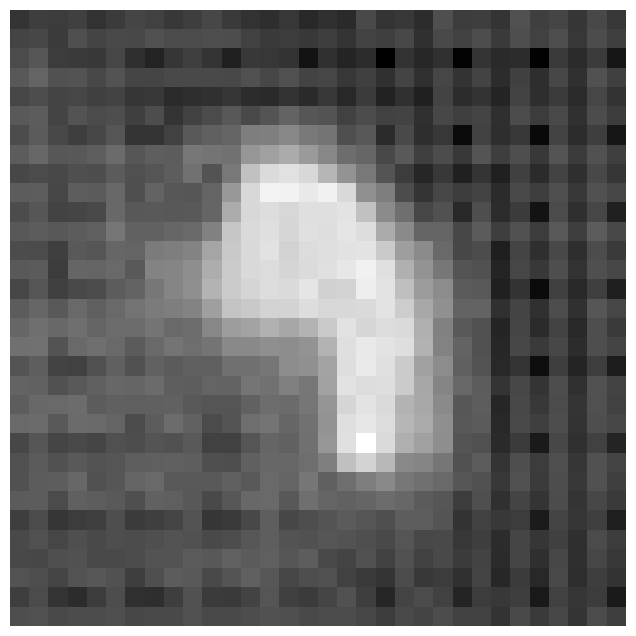

In [ ]:
print(f"low_res_masks shape: {low_res_masks.shape}")
save_volume_viz(low_res_masks.cpu().detach().numpy()[0][0], slice_indices = None, show=True)

In [ ]:
start_time = time.time()

prev_mask = F.interpolate(low_res_masks,
                            size=roi_image.shape[-3:],
                            mode='trilinear',
                            align_corners=False)

print(f"prev_mask shape: {prev_mask.shape}")
save_volume_viz(prev_mask.cpu().detach().numpy()[0][0], slice_indices = None, show=True)

medsam_seg_prob = torch.sigmoid(prev_mask)  # (1, 1, 64, 64, 64)
medsam_seg_prob = medsam_seg_prob.cpu().detach().numpy().squeeze()
medsam_seg_mask = (medsam_seg_prob > 0.5).astype(np.uint8)


medsam_seg_prob = torch.sigmoid(prev_mask)  # (1, 1, 64, 64, 64)
medsam_seg_prob = medsam_seg_prob.cpu().detach().numpy().squeeze()
medsam_seg_mask = (medsam_seg_prob > 0.5).astype(np.uint8)

print(f"medsam_seg_prob shape: {medsam_seg_prob.shape}")
save_volume_viz(medsam_seg_prob, slice_indices = None, show=True)

pred_ori = data_postprocess(medsam_seg_mask, meta_info)
final_pred[pred_ori!=0] = class_id
mask_pred = final_pred 

print(f"postprocess time: {time.time() - start_time:.2f} seconds")


prev_mask shape: torch.Size([1, 1, 128, 128, 128])


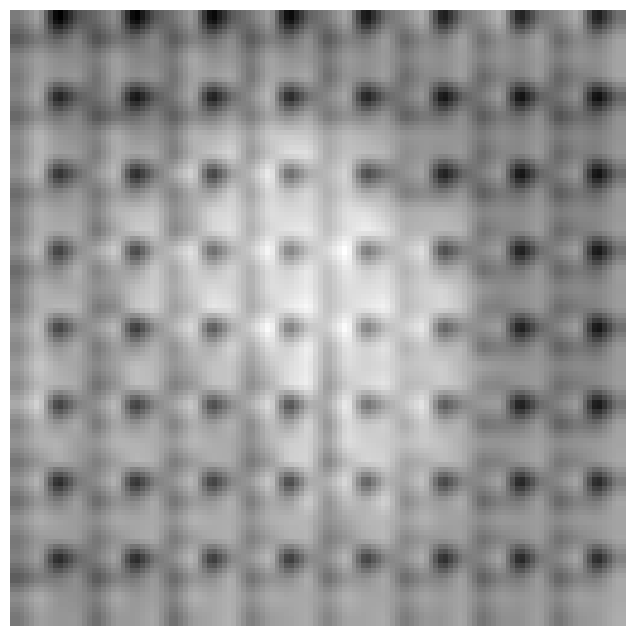

In [ ]:
print(f"final_pred shape: {final_pred.shape}")
save_volume_viz(final_pred, slice_indices = None, show=True)

np.unique(final_pred==class_id)
np.unique(gts==class_id)
print(f"dsc: {compute_dice_coefficient(gts==class_id, final_pred==class_id)}")
print(f"nsd: {compute_multi_class_nsd(gts==class_id, final_pred==class_id, spacing=spacing)}")



medsam_seg_prob shape: (128, 128, 128)


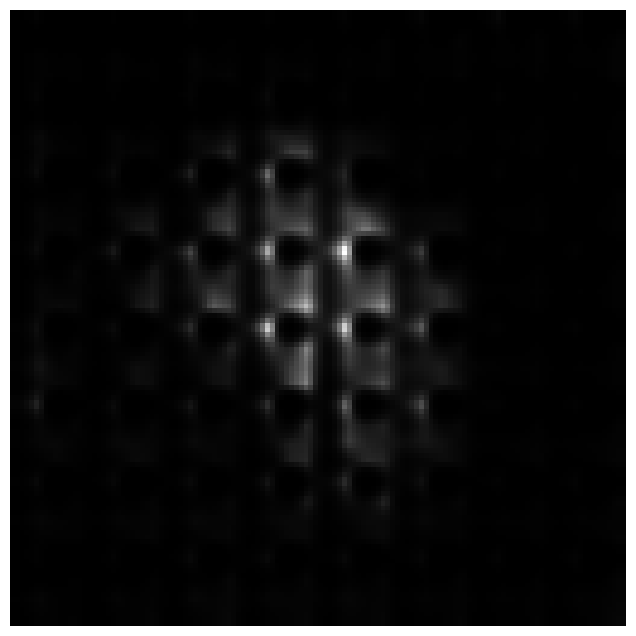

final_pred shape: (63, 512, 512)


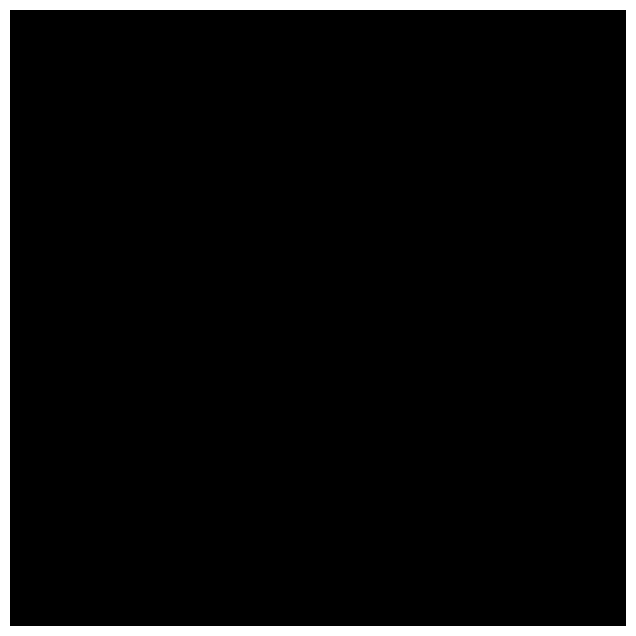

array([False,  True])

dsc: 0.9250534371683532
nsd: 0.8731358985060326
